In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from time import sleep

# Cities to scrape
cities = ["Bangalore", "Hyderabad", "Chennai", "Pune"]

# Initialize lists
Names = []
Flat_types = []
Localities = []
Cities = []
Areas_sqft = []
Interior_statuses = []
Transactions = []
Existing_Floors = []
Total_Floors = []

# Scrape data from each city
for city in cities:
    print(f"Scraping city: {city}")
    # https://www.magicbricks.com/property-for-sale-rent-in-Bangalore/residential-real-estate-Bangalore
    base_url = f"https://www.magicbricks.com/flats-in-{city.lower().replace(' ', '-')}-for-sale-pppfs"
    
    for page in range(1, 11):  # First 10 pages per city (10 x 4 = ~1200 rows)
        print(f"  Page {page}...")
        url = f"{base_url}?page={page}"
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(response.text, "html.parser")

        cards = soup.find_all("div", class_="mb-srp__card")

        for card in cards:
            # Name
            name_tag = card.find("a", class_="mb-srp__card__society--name")
            if name_tag:
                name = name_tag.get_text(strip=True)
            else:
                title_tag = card.find("h2", class_="mb-srp__card--title")
                name = title_tag.get_text(strip=True).split(" for Sale")[0] if title_tag else None
            Names.append(name)

            # Address text
            address_tag = card.find("h2", class_="mb-srp__card--title")
            address_text = address_tag.get_text(strip=True) if address_tag else ""

            # Flat Type
            flat_match = re.search(r"(.*) for Sale in ", address_text)
            flat_type = flat_match.group(1) if flat_match else None
            Flat_types.append(flat_type)

            # Locality & City
            loc_match = re.search(r"in (.+)", address_text)
            if loc_match:
                full_loc = loc_match.group(1).strip()
                parts = [p.strip() for p in full_loc.split(",")]
                if len(parts) == 2:
                    locality = parts[0]
                    city_final = parts[1]
                elif len(parts) == 1:
                    locality = None
                    city_final = parts[0]
                else:
                    locality = None
                    city_final = city
            else:
                locality = None
                city_final = city

            Localities.append(locality)
            Cities.append(city_final)

            # Area(sqft)
            area_tag = card.find("div", class_="mb-srp__card__summary--value")
            if area_tag:
                area_text = area_tag.get_text(strip=True).replace("(", "").replace(")", "")
                area_parts = area_text.split()
                try:
                    area_int = int(area_parts[0].replace(",", ""))
                    Areas_sqft.append(area_int)
                except:
                    Areas_sqft.append(None)
            else:
                Areas_sqft.append(None)

            # Initialize defaults
            furnishing = None
            transaction = None
            existing_floor = None
            total_floor = None

            summary_items = card.find_all("div", class_="mb-srp__card__summary__list--item")
            for item in summary_items:
                label_tag = item.find("div", class_="mb-srp__card__summary--label")
                value_tag = item.find("div", class_="mb-srp__card__summary--value")
                label = label_tag.get_text(strip=True) if label_tag else ""
                value = value_tag.get_text(strip=True) if value_tag else ""

                if "Furnishing" in label:
                    furnishing = value
                elif "Transaction" in label:
                    transaction = value
                elif "Floor" in label:
                    floor_match = re.search(r"(\d+)\s*out of\s*(\d+)", value)
                    if floor_match:
                        existing_floor = int(floor_match.group(1))
                        total_floor = int(floor_match.group(2))

            Interior_statuses.append(furnishing)
            Transactions.append(transaction)
            Existing_Floors.append(existing_floor)
            Total_Floors.append(total_floor)

        sleep(1)

# Build DataFrame
df = pd.DataFrame({
    "Name": Names,
    "Flat Type": Flat_types,
    "Locality": Localities,
    "City": Cities,
    "Area(sqft)": Areas_sqft,
    "Interior Status": Interior_statuses,
    "Transaction": Transactions,
    "Existing Floor": Existing_Floors,
    "Total Floors": Total_Floors
})

# Convert numeric columns
df["Area(sqft)"] = df["Area(sqft)"].astype("Int64")
df["Existing Floor"] = df["Existing Floor"].astype("Int64")
df["Total Floors"] = df["Total Floors"].astype("Int64")

# Fill NaNs (future-proof)
df.fillna({
    "Locality": "Not Mentioned",
    "Interior Status": "Not Mentioned",
    "Transaction": "Not Mentioned",
    "Area(sqft)": 0,
    "Existing Floor": 0,
    "Total Floors": 0
}, inplace=True)

# Save to CSV
df.to_csv("Flats_MultiCity_Clean.csv", index=False, encoding="utf-8-sig")
print("✅ Data saved to 'Flats_MultiCity_Clean.csv'")


Scraping city: Bangalore
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
Scraping city: Hyderabad
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
Scraping city: Chennai
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
Scraping city: Pune
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
✅ Data saved to 'Flats_MultiCity_Clean.csv'


In [2]:
pd.read_csv("Flats_MultiCity_Clean.csv")

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,Hoysala Habitat,2 BHK Flat,Yelahanka,Bangalore,1282,Semi-Furnished,Resale,1,7
1,2 BHK Flat,2 BHK Flat,Not Mentioned,Bangalore,1184,Unfurnished,Resale,4,4
2,GM Infinite Daffodils,3 BHK Flat,Tumkur Road,Bangalore,1650,Semi-Furnished,Resale,19,20
3,SMD Altezz,3 BHK Flat,Whitefield,Bangalore,1450,Furnished,Resale,2,9
4,SLV Central Park,3 BHK Flat,Old Madras Road,Bangalore,1500,Semi-Furnished,Resale,11,11
...,...,...,...,...,...,...,...,...,...
1195,2 BHK Flat,2 BHK Flat,Not Mentioned,Pune,650,Unfurnished,Resale,4,5
1196,Krishna Icon,2 BHK Flat,Not Mentioned,Pune,670,Unfurnished,Resale,2,9
1197,Krishna Icon,2 BHK Flat,Not Mentioned,Pune,656,Furnished,Resale,5,9
1198,Krishna Icon,2 BHK Flat,Not Mentioned,Pune,653,Semi-Furnished,Resale,7,8


In [13]:
df.isnull().sum()

Name               0
Flat Type          0
Locality           0
City               0
Area(sqft)         0
Interior Status    0
Transaction        0
Existing Floor     0
Total Floors       0
dtype: int64

In [7]:
df.isnull().sum()/len(df)

Name               0.0
Flat Type          0.0
Locality           0.0
City               0.0
Area(sqft)         0.0
Interior Status    0.0
Transaction        0.0
Existing Floor     0.0
Total Floors       0.0
dtype: float64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             1200 non-null   object
 1   Flat Type        1200 non-null   object
 2   Locality         1200 non-null   object
 3   City             1200 non-null   object
 4   Area(sqft)       1200 non-null   Int64 
 5   Interior Status  1200 non-null   object
 6   Transaction      1200 non-null   object
 7   Existing Floor   1200 non-null   Int64 
 8   Total Floors     1200 non-null   Int64 
dtypes: Int64(3), object(6)
memory usage: 88.0+ KB


In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from time import sleep

# Cities to scrape
cities = ["Bangalore", "Hyderabad", "Chennai", "Pune"]

# Initialize lists
Names = []
Flat_types = []
Localities = []
Cities = []
Areas_sqft = []
Interior_statuses = []
Transactions = []
Existing_Floors = []
Total_Floors = []

# Scrape data from each city
for city in cities:
    print(f"Scraping city: {city}")
    base_url = f"https://www.magicbricks.com/flats-in-{city.lower().replace(' ', '-')}-for-sale-pppfs"

    for page in range(1, 11):  # First 10 pages per city
        print(f"  Page {page}...")
        url = f"{base_url}?page={page}"
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
        soup = BeautifulSoup(response.text, "html.parser")

        cards = soup.find_all("div", class_="mb-srp__card")

        for card in cards:
            # Name
            name_tag = card.find("a", class_="mb-srp__card__society--name")
            if name_tag:
                name = name_tag.get_text(strip=True)
            else:
                title_tag = card.find("h2", class_="mb-srp__card--title")
                name = title_tag.get_text(strip=True).split(" for Sale")[0] if title_tag else None
            Names.append(name)

            # Address text
            address_tag = card.find("h2", class_="mb-srp__card--title")
            address_text = address_tag.get_text(strip=True) if address_tag else ""

            # Flat Type
            flat_match = re.search(r"(.*) for Sale in ", address_text)
            flat_type = flat_match.group(1) if flat_match else None
            Flat_types.append(flat_type)

            # Locality & City
            loc_match = re.search(r"in (.+)", address_text)
            if loc_match:
                full_loc = loc_match.group(1).strip()
                parts = [p.strip() for p in full_loc.split(",")]
                if len(parts) == 2:
                    locality = parts[0]
                    city_final = parts[1]
                elif len(parts) == 1:
                    locality = None
                    city_final = parts[0]
                else:
                    locality = None
                    city_final = city
            else:
                locality = None
                city_final = city

            Localities.append(locality)
            Cities.append(city_final)

            # Area(sqft)
            area_tag = card.find("div", class_="mb-srp__card__summary--value")
            if area_tag:
                area_text = area_tag.get_text(strip=True).replace("(", "").replace(")", "")
                area_parts = area_text.split()
                Areas_sqft.append(area_parts[0] if area_parts else None)
            else:
                Areas_sqft.append(None)

            # Initialize defaults
            furnishing = None
            transaction = None
            existing_floor = None
            total_floor = None

            summary_items = card.find_all("div", class_="mb-srp__card__summary__list--item")
            for item in summary_items:
                label_tag = item.find("div", class_="mb-srp__card__summary--label")
                value_tag = item.find("div", class_="mb-srp__card__summary--value")
                label = label_tag.get_text(strip=True) if label_tag else ""
                value = value_tag.get_text(strip=True) if value_tag else ""

                if "Furnishing" in label:
                    furnishing = value
                elif "Transaction" in label:
                    transaction = value
                elif "Floor" in label:
                    floor_match = re.search(r"(\d+)\s*out of\s*(\d+)", value)
                    if floor_match:
                        existing_floor = floor_match.group(1)
                        total_floor = floor_match.group(2)

            Interior_statuses.append(furnishing)
            Transactions.append(transaction)
            Existing_Floors.append(existing_floor)
            Total_Floors.append(total_floor)

        sleep(1)

# Build DataFrame
df = pd.DataFrame({
    "Name": Names,
    "Flat Type": Flat_types,
    "Locality": Localities,
    "City": Cities,
    "Area(sqft)": Areas_sqft,
    "Interior Status": Interior_statuses,
    "Transaction": Transactions,
    "Existing Floor": Existing_Floors,
    "Total Floors": Total_Floors
})

# Just save as-is without cleaning
df.to_csv("Flats_MultiCity_Raw.csv", index=False, encoding="utf-8-sig")
print("✅ Raw data saved to 'Flats_MultiCity_Raw.csv'")


Scraping city: Bangalore
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
Scraping city: Hyderabad
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
Scraping city: Chennai
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
Scraping city: Pune
  Page 1...
  Page 2...
  Page 3...
  Page 4...
  Page 5...
  Page 6...
  Page 7...
  Page 8...
  Page 9...
  Page 10...
✅ Raw data saved to 'Flats_MultiCity_Raw.csv'


In [21]:
df.isnull().sum()/len(df)

Name               0.000000
Flat Type          0.000000
Locality           0.158333
City               0.000000
Area(sqft)         0.000000
Interior Status    0.008333
Transaction        0.002500
Existing Floor     0.095000
Total Floors       0.095000
dtype: float64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             1200 non-null   object
 1   Flat Type        1200 non-null   object
 2   Locality         1010 non-null   object
 3   City             1200 non-null   object
 4   Area(sqft)       1200 non-null   object
 5   Interior Status  1190 non-null   object
 6   Transaction      1197 non-null   object
 7   Existing Floor   1086 non-null   object
 8   Total Floors     1086 non-null   object
dtypes: object(9)
memory usage: 84.5+ KB


In [23]:
df

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,Hoysala Habitat,2 BHK Flat,Yelahanka,Bangalore,1282,Semi-Furnished,Resale,1,7
1,2 BHK Flat,2 BHK Flat,None,Bangalore,1184,Unfurnished,Resale,4,4
2,GM Infinite Daffodils,3 BHK Flat,Tumkur Road,Bangalore,1650,Semi-Furnished,Resale,19,20
3,SMD Altezz,3 BHK Flat,Whitefield,Bangalore,1450,Furnished,Resale,2,9
4,SLV Central Park,3 BHK Flat,Old Madras Road,Bangalore,1500,Semi-Furnished,Resale,11,11
...,...,...,...,...,...,...,...,...,...
1195,2 BHK Flat,2 BHK Flat,None,Pune,650,Unfurnished,Resale,4,5
1196,Krishna Icon,2 BHK Flat,None,Pune,670,Unfurnished,Resale,2,9
1197,Krishna Icon,2 BHK Flat,None,Pune,656,Furnished,Resale,5,9
1198,Krishna Icon,2 BHK Flat,None,Pune,653,Semi-Furnished,Resale,7,8


In [24]:
df.isnull().sum()

Name                 0
Flat Type            0
Locality           190
City                 0
Area(sqft)           0
Interior Status     10
Transaction          3
Existing Floor     114
Total Floors       114
dtype: int64

<h2 style="text-align:center; font-weight:bold; color:#0E76A8; background-color:#D6F0F5; padding:12px 20px; border-radius:10px;">
  🔍 Data Inspection
</h2>


In [4]:
df = pd.read_csv("MagicBricks_data cleaned.csv")
df.head()

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3,4
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8,14
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2,4
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5,12
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3,3


# __Intial Data Inspection__

### __1. Importing Required Libraries__

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

### 2.__Loading Dataset__

In [15]:
df = pd.read_csv("Flats_MultiCity_Raw.csv")
df

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3.0,4.0
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8.0,14.0
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2.0,4.0
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5.0,12.0
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3.0,3.0
...,...,...,...,...,...,...,...,...,...
1195,Tayal K Town Kiwale,3 BHK Flat,NaN,Pune,1041,Unfurnished,New Property,10.0,20.0
1196,VTP Belair E And F Building,2 BHK Flat,Mhalunge Nande Road,Pune,600,Unfurnished,Resale,1.0,23.0
1197,Heaven Park,2 BHK Flat,Kondhwa,Pune,760,Furnished,Resale,3.0,4.0
1198,1 BHK Flat,1 BHK Flat,Narhe,Pune,250,Unfurnished,Resale,1.0,4.0


## __3. Basic Dataset Overview__

#### Checking the shape  ---> df.shape

- Quick snapshot of data size.
- Validate data loading.
- Guide next steps in cleaning and exploration

In [16]:
df.shape # No.of rows and No.of Columns

(1200, 9)

#### Preview first few rows ---> df.head()

- It’s one of the fastest ways to:
- Understand your data.
- Confirm it’s loaded properly.
- Plan your next cleaning and analysis steps.

In [18]:
df.head()

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3.0,4.0
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8.0,14.0
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2.0,4.0
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5.0,12.0
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3.0,3.0


In [19]:
df.tail()

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
1195,Tayal K Town Kiwale,3 BHK Flat,NaN,Pune,1041,Unfurnished,New Property,10.0,20.0
1196,VTP Belair E And F Building,2 BHK Flat,Mhalunge Nande Road,Pune,600,Unfurnished,Resale,1.0,23.0
1197,Heaven Park,2 BHK Flat,Kondhwa,Pune,760,Furnished,Resale,3.0,4.0
1198,1 BHK Flat,1 BHK Flat,Narhe,Pune,250,Unfurnished,Resale,1.0,4.0
1199,Studio Apartment,Studio Apartment,Mumbai Pune Expressway,Pune,490,Unfurnished,Resale,4.0,26.0


#### Data types and non-null counts ---> df.info()

- Checking data types and non-null counts helps you:
- Confirm the structure of your data.
- Plan conversions (e.g., to numeric or datetime).
- Understand what cleaning is needed.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             1200 non-null   object 
 1   Flat Type        1200 non-null   object 
 2   Locality         1012 non-null   object 
 3   City             1200 non-null   object 
 4   Area(sqft)       1200 non-null   int64  
 5   Interior Status  1191 non-null   object 
 6   Transaction      1197 non-null   object 
 7   Existing Floor   1098 non-null   float64
 8   Total Floors     1098 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 84.5+ KB


#### Quick summary statistics ---> df.describe()

- Understand the typical values and spread of your data.
- Detect outliers or unexpected ranges early.
- Plan cleaning steps like handling missing values, scaling, or fixing errors.

In [22]:
df.describe()

,Area(sqft),Existing Floor,Total Floors
count,1200.000000,1098.000000,1098.000000
mean,1131.975833,5.424408,9.785064
std,605.666271,5.536506,8.410247
min,11.000000,1.000000,1.000000
25%,720.000000,2.000000,4.000000
50%,1050.000000,3.000000,6.000000
75%,1371.000000,7.000000,13.000000
max,6500.000000,36.000000,45.000000


#### Column names ---> df.columns

- To make sure all columns loaded correctly and have the expected names.
- To spot typos, extra spaces, or “Unnamed” columns.
- To plan renaming for clarity before analysis.

In [23]:
df.columns

Index(['Name', 'Flat Type', 'Locality', 'City', 'Area(sqft)',
       'Interior Status', 'Transaction', 'Existing Floor', 'Total Floors'],
      dtype='object')

## __4. Checking for Missing Values__

- Find out which columns have gaps or incomplete data.
- Decide whether to fill, drop, or ignore missing values.
- Avoid errors in analysis caused by unexpected blanks.

In [24]:
df.isnull().sum()

Name                 0
Flat Type            0
Locality           188
City                 0
Area(sqft)           0
Interior Status      9
Transaction          3
Existing Floor     102
Total Floors       102
dtype: int64

- we likely need to handle missing values in __Locality, Interior Status, Transaction, Existing Floor, and Total Floors__ before further analysis
- __over view on missing values__:

   - Locality has 190 missing values 
   - Interior Status has 10 missing values
   - Transaction has 3 missing values
   - Existing Floor has 114 missing values
   - Total Floors has 114 missing values

## __5. Checking for Duplicates__

- Checking for duplicates is like making sure you don’t have the same row repeated twice in your data.
    - Find and remove repeated rows that can skew your analysis.
    - Keep your data clean and accurate.
    - Avoid counting the same record multiple times by mistake.

In [25]:
df.duplicated().sum() # Count duplicates

5

In [26]:
df[df.duplicated()] # Display duplicate rows

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
1033,Sai Smruti,1 BHK Flat,Narhe,Pune,284,Unfurnished,Resale,4.0,4.0
1136,DBs Diamond Apartment,3 BHK Flat,Shivajinagar,Pune,1368,Furnished,Resale,NaN,NaN
1154,Vilas Javdekar Yashwin Supernova,3 BHK Flat,Wakad,Pune,707,Unfurnished,Resale,22.0,22.0
1158,AWHO Vijay Vihar,3 BHK Flat,Wagholi,Pune,1278,Semi-Furnished,Resale,7.0,14.0
1159,AWHO Vijay Vihar,3 BHK Flat,Wagholi,Pune,1278,Semi-Furnished,Resale,7.0,14.0


## __6. Analyzing Data Types__

- Analyzing data types is like checking whether each item in your toolbox is the right kind before you start working.-
    - Confirm which columns are numbers, text, dates, or categories.
    - Make sure data types match what you expect for analysis.
    - Plan any conversions needed to avoid errors later.

In [27]:
df.dtypes

Name                object
Flat Type           object
Locality            object
City                object
Area(sqft)           int64
Interior Status     object
Transaction         object
Existing Floor     float64
Total Floors       float64
dtype: object

- All columns are stored as text __(object)__ except __Existing Floor__ and __Total Floors__, which are numeric __(float64)__.
- The __Area(sqft)__ column is stored as __text (object)__, but it should be __numeric__, so we need to convert it.
- __Existing Floor__ and __Total Floors__ are numeric as __floats__, but since they represent whole numbers, they should be __converted to integers__.

<h2 style="text-align:center; font-weight:bold; color:#0E76A8; background-color:#D6F0F5; padding:12px 20px; border-radius:10px;">
  🧹 Data Cleaning
</h2>


### 1. __Changing Data type__ 

#### Convert Area(sqft) to numeric

In [29]:
df["Area(sqft)"]=df["Area(sqft)"].replace("Ready",0).astype("int64")

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             1200 non-null   object 
 1   Flat Type        1200 non-null   object 
 2   Locality         1012 non-null   object 
 3   City             1200 non-null   object 
 4   Area(sqft)       1200 non-null   int64  
 5   Interior Status  1191 non-null   object 
 6   Transaction      1197 non-null   object 
 7   Existing Floor   1098 non-null   float64
 8   Total Floors     1098 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 84.5+ KB


####  Convert Existing Floor and Total Floors from __Float to integers__

In [32]:
df["Existing Floor"] = df["Existing Floor"].astype("Int64")
df["Total Floors"] = df["Total Floors"].astype("Int64")

In [33]:
df.dtypes

Name               object
Flat Type          object
Locality           object
City               object
Area(sqft)          int64
Interior Status    object
Transaction        object
Existing Floor      Int64
Total Floors        Int64
dtype: object

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             1200 non-null   object
 1   Flat Type        1200 non-null   object
 2   Locality         1012 non-null   object
 3   City             1200 non-null   object
 4   Area(sqft)       1200 non-null   int64 
 5   Interior Status  1191 non-null   object
 6   Transaction      1197 non-null   object
 7   Existing Floor   1098 non-null   Int64 
 8   Total Floors     1098 non-null   Int64 
dtypes: Int64(2), int64(1), object(6)
memory usage: 86.8+ KB


### 2. __Handle missing values__

In [35]:
df.isnull().sum()

Name                 0
Flat Type            0
Locality           188
City                 0
Area(sqft)           0
Interior Status      9
Transaction          3
Existing Floor     102
Total Floors       102
dtype: int64

- Locality: 190 missing entries (some locations not specified)
- Interior Status: 10 missing entries 
- Transaction: 3 missing entries 
- Existing Floor: 114 missing entries 
- Total Floors: 114 missing entries

In [36]:
df[df["Transaction"].isna()] #Categorical

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
63,Nirmal Residency,3 BHK Flat,Doddaballapur Main Road,Bangalore,1411,Unfurnished,NaN,4,5
140,MSR Dew Drops,2 BHK Flat,Sarjapur Road,Bangalore,1205,NaN,NaN,1,4
892,AVENUE MAJESTIC,2 BHK Flat,Vyasarpadi,Chennai,590,Unfurnished,NaN,2,3


In [37]:
df[df["Existing Floor"].isna()] #Numeric data

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
12,3 BHK Flat,3 BHK Flat,Nisarga Layout,Bangalore,2057,Furnished,New Property,<NA>,<NA>
18,Sowmya Sarovar,2 BHK Flat,Thanisandra,Bangalore,1265,NaN,Resale,<NA>,<NA>
25,Sai Siri Heritage,3 BHK Flat,Kengeri,Bangalore,1150,Semi-Furnished,Resale,<NA>,<NA>
26,Abhee Nandana,2 BHK Flat,Harlur,Bangalore,700,Semi-Furnished,Resale,<NA>,<NA>
35,Sobha Sapphire,2 BHK Flat,Bellary Road,Bangalore,1420,Semi-Furnished,Resale,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
1074,Anandgram Talegaon Dhamdere,1 BHK Flat,Talegaon Dhamdhere,Pune,328,Unfurnished,Resale,<NA>,<NA>
1084,Abhinav Pebbles Greenfield,3 BHK Flat,Tathawade Pimpri Chinchwad,Pune,1008,Unfurnished,Resale,<NA>,<NA>
1117,Surya Nagri cooperative society,2 BHK Flat,NaN,Pune,720,Unfurnished,Resale,<NA>,<NA>
1135,DBs Diamond Apartment,3 BHK Flat,Shivajinagar,Pune,1368,Furnished,Resale,<NA>,<NA>


In [38]:
df[df["Total Floors"].isna()] #Numeric data

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
12,3 BHK Flat,3 BHK Flat,Nisarga Layout,Bangalore,2057,Furnished,New Property,<NA>,<NA>
18,Sowmya Sarovar,2 BHK Flat,Thanisandra,Bangalore,1265,NaN,Resale,<NA>,<NA>
25,Sai Siri Heritage,3 BHK Flat,Kengeri,Bangalore,1150,Semi-Furnished,Resale,<NA>,<NA>
26,Abhee Nandana,2 BHK Flat,Harlur,Bangalore,700,Semi-Furnished,Resale,<NA>,<NA>
35,Sobha Sapphire,2 BHK Flat,Bellary Road,Bangalore,1420,Semi-Furnished,Resale,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
1074,Anandgram Talegaon Dhamdere,1 BHK Flat,Talegaon Dhamdhere,Pune,328,Unfurnished,Resale,<NA>,<NA>
1084,Abhinav Pebbles Greenfield,3 BHK Flat,Tathawade Pimpri Chinchwad,Pune,1008,Unfurnished,Resale,<NA>,<NA>
1117,Surya Nagri cooperative society,2 BHK Flat,NaN,Pune,720,Unfurnished,Resale,<NA>,<NA>
1135,DBs Diamond Apartment,3 BHK Flat,Shivajinagar,Pune,1368,Furnished,Resale,<NA>,<NA>


 __Filling Null values__

 | **Method** | **Used For**           | **What It Does**                       | **When to Use**                                        |
| ---------- | ---------------------- | -------------------------------------- | ------------------------------------------------------ |
| **Mean**   | Numeric data           | Calculates the **average** value       | When data is numeric and has **no big outliers**       |
| **Median** | Numeric data           | Finds the **middle** value when sorted | When data is numeric and has **outliers**              |
| **Mode**   | Categorical or numeric | Finds the **most frequent** value      | When filling **categorical data** or repeating numbers |


In [39]:
df["Locality"]=df["Locality"].fillna(df["Locality"].mode()[0])
df["Interior Status"]=df["Interior Status"].fillna(df["Interior Status"].mode()[0])
df["Transaction"]=df["Transaction"].fillna(df["Transaction"].mode()[0])

In [40]:
df["Total Floors"]=df["Total Floors"].fillna(df["Total Floors"].median())

In [41]:
df["Existing Floor"]=df["Existing Floor"].fillna(df["Existing Floor"].median())

#### Zero null values

In [42]:
df.isnull().sum()

Name               0
Flat Type          0
Locality           0
City               0
Area(sqft)         0
Interior Status    0
Transaction        0
Existing Floor     0
Total Floors       0
dtype: int64

## 3. __Removing Duplicates__

- Removing duplicates ensures you only have unique records, so your results are accurate, reliable, and not biased by repeated entries.
- If a row matches every column exactly with another row, we consider it a duplicate and remove that duplicate row.

In [43]:
df.duplicated().sum() # Finding duplicate rows 

5

In [44]:
duplicates = df[df.duplicated()]
duplicates

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
1033,Sai Smruti,1 BHK Flat,Narhe,Pune,284,Unfurnished,Resale,4,4
1136,DBs Diamond Apartment,3 BHK Flat,Shivajinagar,Pune,1368,Furnished,Resale,3,6
1154,Vilas Javdekar Yashwin Supernova,3 BHK Flat,Wakad,Pune,707,Unfurnished,Resale,22,22
1158,AWHO Vijay Vihar,3 BHK Flat,Wagholi,Pune,1278,Semi-Furnished,Resale,7,14
1159,AWHO Vijay Vihar,3 BHK Flat,Wagholi,Pune,1278,Semi-Furnished,Resale,7,14


### Example: Name coloumn

In [45]:
df[df['Name'] == 'Life Montage']

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors


In [46]:
df.drop_duplicates(inplace= True, keep= 'first')
df

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3,4
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8,14
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2,4
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5,12
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3,3
...,...,...,...,...,...,...,...,...,...
1195,Tayal K Town Kiwale,3 BHK Flat,Sarjapur Road,Pune,1041,Unfurnished,New Property,10,20
1196,VTP Belair E And F Building,2 BHK Flat,Mhalunge Nande Road,Pune,600,Unfurnished,Resale,1,23
1197,Heaven Park,2 BHK Flat,Kondhwa,Pune,760,Furnished,Resale,3,4
1198,1 BHK Flat,1 BHK Flat,Narhe,Pune,250,Unfurnished,Resale,1,4


__By droping a whole row index value will also get droped, but index dosen't change in main data frame we have to change it to proper index value__

In [47]:
df.reset_index(inplace=True, drop = True)
df

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3,4
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8,14
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2,4
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5,12
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3,3
...,...,...,...,...,...,...,...,...,...
1190,Tayal K Town Kiwale,3 BHK Flat,Sarjapur Road,Pune,1041,Unfurnished,New Property,10,20
1191,VTP Belair E And F Building,2 BHK Flat,Mhalunge Nande Road,Pune,600,Unfurnished,Resale,1,23
1192,Heaven Park,2 BHK Flat,Kondhwa,Pune,760,Furnished,Resale,3,4
1193,1 BHK Flat,1 BHK Flat,Narhe,Pune,250,Unfurnished,Resale,1,4


### Re-check data
- Make sure everything looks correct:

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             1195 non-null   object
 1   Flat Type        1195 non-null   object
 2   Locality         1195 non-null   object
 3   City             1195 non-null   object
 4   Area(sqft)       1195 non-null   int64 
 5   Interior Status  1195 non-null   object
 6   Transaction      1195 non-null   object
 7   Existing Floor   1195 non-null   Int64 
 8   Total Floors     1195 non-null   Int64 
dtypes: Int64(2), int64(1), object(6)
memory usage: 86.5+ KB


In [49]:
df.dtypes #Check data types

Name               object
Flat Type          object
Locality           object
City               object
Area(sqft)          int64
Interior Status    object
Transaction        object
Existing Floor      Int64
Total Floors        Int64
dtype: object

In [50]:
df.isnull().sum() #Check missing values

Name               0
Flat Type          0
Locality           0
City               0
Area(sqft)         0
Interior Status    0
Transaction        0
Existing Floor     0
Total Floors       0
dtype: int64

# Saving cleaned dataset

In [51]:
df.to_csv("MagicBricks_data cleaned.csv", index=False)

In [52]:
df

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3,4
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8,14
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2,4
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5,12
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3,3
...,...,...,...,...,...,...,...,...,...
1190,Tayal K Town Kiwale,3 BHK Flat,Sarjapur Road,Pune,1041,Unfurnished,New Property,10,20
1191,VTP Belair E And F Building,2 BHK Flat,Mhalunge Nande Road,Pune,600,Unfurnished,Resale,1,23
1192,Heaven Park,2 BHK Flat,Kondhwa,Pune,760,Furnished,Resale,3,4
1193,1 BHK Flat,1 BHK Flat,Narhe,Pune,250,Unfurnished,Resale,1,4


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             1195 non-null   object
 1   Flat Type        1195 non-null   object
 2   Locality         1195 non-null   object
 3   City             1195 non-null   object
 4   Area(sqft)       1195 non-null   int64 
 5   Interior Status  1195 non-null   object
 6   Transaction      1195 non-null   object
 7   Existing Floor   1195 non-null   Int64 
 8   Total Floors     1195 non-null   Int64 
dtypes: Int64(2), int64(1), object(6)
memory usage: 86.5+ KB


<h2 style="text-align:center; font-weight:bold; color:#0E76A8; background-color:#D6F0F5; padding:12px 20px; border-radius:10px;">
  🗂️ Data Exploring
</h2>


In [54]:
print("Shape of the dataset:", df.shape)

Shape of the dataset: (1195, 9)


In [55]:
print("Column Names:\n", df.columns.tolist())

Column Names:
 ['Name', 'Flat Type', 'Locality', 'City', 'Area(sqft)', 'Interior Status', 'Transaction', 'Existing Floor', 'Total Floors']


In [56]:
print("Data Types:\n", df.dtypes)

Data Types:
 Name               object
Flat Type          object
Locality           object
City               object
Area(sqft)          int64
Interior Status    object
Transaction        object
Existing Floor      Int64
Total Floors        Int64
dtype: object


In [57]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Name               0
Flat Type          0
Locality           0
City               0
Area(sqft)         0
Interior Status    0
Transaction        0
Existing Floor     0
Total Floors       0
dtype: int64


In [58]:
print("Unique Values per Column:\n", df.nunique())

Unique Values per Column:
 Name               706
Flat Type           11
Locality           507
City                 4
Area(sqft)         607
Interior Status      3
Transaction          2
Existing Floor      34
Total Floors        44
dtype: int64


In [59]:
print("Statistical Summary (Numeric Columns):\n", df.describe())

Statistical Summary (Numeric Columns):
         Area(sqft)  Existing Floor  Total Floors
count  1195.000000          1195.0        1195.0
mean   1132.599163        5.204184       9.45272
std     606.243784        5.326853      8.118164
min      11.000000             1.0           1.0
25%     720.000000             2.0           4.0
50%    1050.000000             3.0           6.0
75%    1371.000000             7.0          12.5
max    6500.000000            36.0          45.0


<h2 style="text-align:center; font-weight:bold; color:#0E76A8; background-color:#D6F0F5; padding:12px 20px; border-radius:10px;">
  📊 Data Visualization
</h2>


In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns 
import numpy as np
!pip install squarify
import squarify

In [61]:
df = pd.read_csv("MagicBricks_data cleaned.csv")
df.head()

,Name,Flat Type,Locality,City,Area(sqft),Interior Status,Transaction,Existing Floor,Total Floors
0,SVS Sri Nilayam,3 BHK Flat,Devki Apparao Layout,Bangalore,1275,Furnished,Resale,3,4
1,Provident Park Square,3 BHK Flat,Phase 2nd Judicial Layout,Bangalore,1000,Unfurnished,New Property,8,14
2,Sterling Shribagh,3 BHK Flat,Malleshwaram,Bangalore,2430,Unfurnished,Resale,2,4
3,Salarpuria Sattva Melody,3 BHK Flat,Mysore Road,Bangalore,1811,Semi-Furnished,Resale,5,12
4,LK Gloria,3 BHK Flat,Amrutahalli,Bangalore,1080,Semi-Furnished,Resale,3,3


<h2 style="text-align:center; font-weight:bold; color:#0E76A8; background-color:#E3F2FD; padding:12px 20px; border-radius:10px;">
   📈 Univariate Analysis
</h2>


###  __Univariate Analysis__

- It is the analysis of **a single variable (column)** at a time.
- Helps to understand the **distribution** and **nature** of the data.
- Used to identify **patterns**, **outliers**, and **summary statistics**.
- No relationship with other variables is considered.
- It is often the **first step** in data exploration (EDA).


### __Types of Univariate Analysis__

| Variable Type       | Examples                             | Common Techniques                                      |
|---------------------|--------------------------------------|--------------------------------------------------------|
| **Categorical**     | `Interior Status`, `Transaction`, `City`  | Frequency table, Count plot, Bar chart, Pie chart     |
| **Numerical**       | `Area(sqft)`, `Existing Floors`, `Total Floors`| Summary stats (mean, median, std), Histogram, Box plot, KDE plot |


<div style="background:#FFF4E0; border:2px solid #FFA500; display:inline-block; padding:10px 20px; border-radius:25px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); font-weight:bold; font-size:16px;">
  🔢 For Numerical Columns
</div>


<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#E5F6FD; padding:8px 15px; border-radius:8px; display:inline-block;">
  📊 Histogram View
</div>


# __Area__

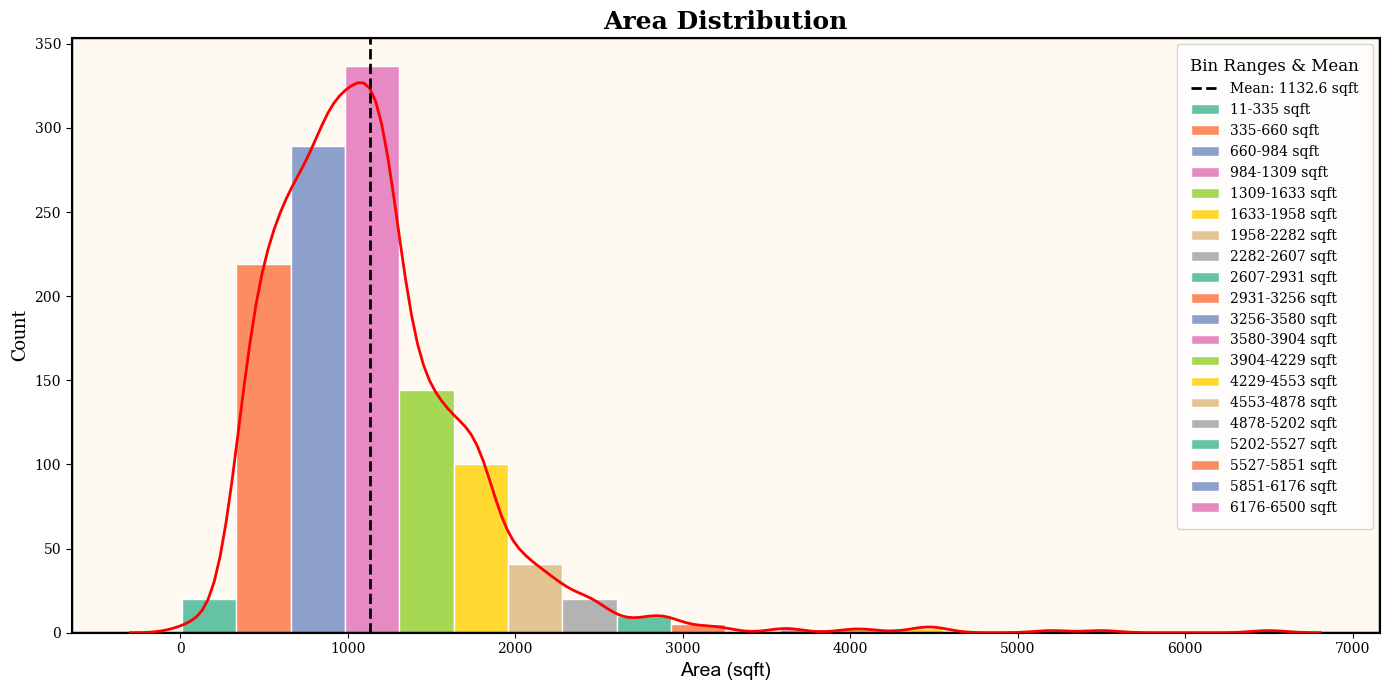

In [62]:
# Convert Area(sqft) to numeric
area_data = pd.to_numeric(df["Area(sqft)"], errors="coerce").dropna()

# Compute histogram manually
counts, bin_edges = np.histogram(area_data, bins=20)

# Colors for bars
colors = sns.color_palette("Set2", len(counts))

# Custom font
plt.rcParams["font.family"] = "serif"

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor("#fef9f1")  # Light beige

# Plot histogram bars
for i in range(len(counts)):
    ax.bar(
        bin_edges[i], counts[i],
        width=bin_edges[i+1] - bin_edges[i],
        color=colors[i],
        edgecolor="white",
        align="edge",
        label=f"{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f} sqft"
    )

# KDE curve
x_kde = np.linspace(area_data.min(), area_data.max(), 500)
kde = sns.kdeplot(area_data, bw_adjust=0.7, color="red", linewidth=2, ax=ax)
y_kde = kde.get_lines()[-1].get_ydata()
bin_width = bin_edges[1] - bin_edges[0]
y_kde_scaled = y_kde * len(area_data) * bin_width
kde.get_lines()[-1].set_ydata(y_kde_scaled)

# Mean line
mean_value = area_data.mean()
ax.axvline(mean_value, color="black", linestyle="--", linewidth=2, label=f"Mean: {mean_value:.1f} sqft")

# Titles and labels
ax.set_title("Area Distribution", fontsize=18, fontweight="bold")
ax.set_xlabel("Area (sqft)", fontsize=14, fontname="Arial")
ax.set_ylabel("Count", fontsize=14, fontname="Georgia")

# Custom legend
ax.legend(loc="upper right", title="Bin Ranges & Mean", title_fontsize=12, fontsize=10,
          frameon=True, fancybox=True, borderpad=1)

# Add border around the plot
rect = patches.Rectangle(
    (0, 0), 1, 1, transform=ax.transAxes,
    linewidth=2.5, edgecolor="black", facecolor="none"
)
ax.add_patch(rect)

plt.tight_layout()
plt.show()


### __Histogram__

- A **histogram** is used to visualize the **distribution of a numerical variable**.
- It splits the data into **intervals (bins)** and shows the **count or frequency** of values in each bin.
- Helps in understanding:
  - **Shape of the distribution** (normal, skewed, bimodal, etc.)
  - **Range** of values
  - **Central tendency** and **spread**
  - **Outliers** or unusual spikes
- Ideal for continuous variables like `Price`, `Area`, `Age`, etc.
- Commonly used in **EDA (Exploratory Data Analysis)**.

-----

### __Summary Histogram__

- Used for **numerical data**.
- Shows how data is **distributed across ranges**.
- Each bar represents a **bin (value range)**.
- Helps spot patterns like skewness, peaks, or gaps.
- Great for understanding data spread and central values.
----

### __Insights of Area__

- The histogram displays the **distribution of property sizes** (Area in sqft), divided into 20 colored bins.
- Each bar represents the **count of properties** within a specific area range.
- The **KDE (red curve)** shows the **smoothed shape of the distribution**, making it easier to observe the density pattern.
- A **dashed black line** marks the **mean area**, giving a reference point for the average property size.
- The distribution helps identify:
  - Whether most properties fall in small, medium, or large area ranges.
  - **Skewness** in the data (e.g., if more properties are smaller or larger than average).
  - Any **unusual spikes** or **gaps**, indicating concentration or lack of listings in certain size ranges.
- This visualization is very helpful for:
  - **Buyers** understanding common flat sizes.
  - **Sellers/builders** aligning offerings with market trends.
-----

### __Summary Insights of Area__

- Shows how flat sizes are distributed across different area ranges.
- Colored bars = number of listings in each area bin.
- Red curve (KDE) shows smooth distribution pattern.
- Dashed black line marks the **average flat size**.
- Most listings appear to cluster around specific area ranges.
- Helps identify typical and rare flat sizes in the dataset.


<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#E5F6FD; padding:8px 15px; border-radius:8px; display:inline-block;">
  📈 KDE Plot View
</div>


# __Existing Floor__

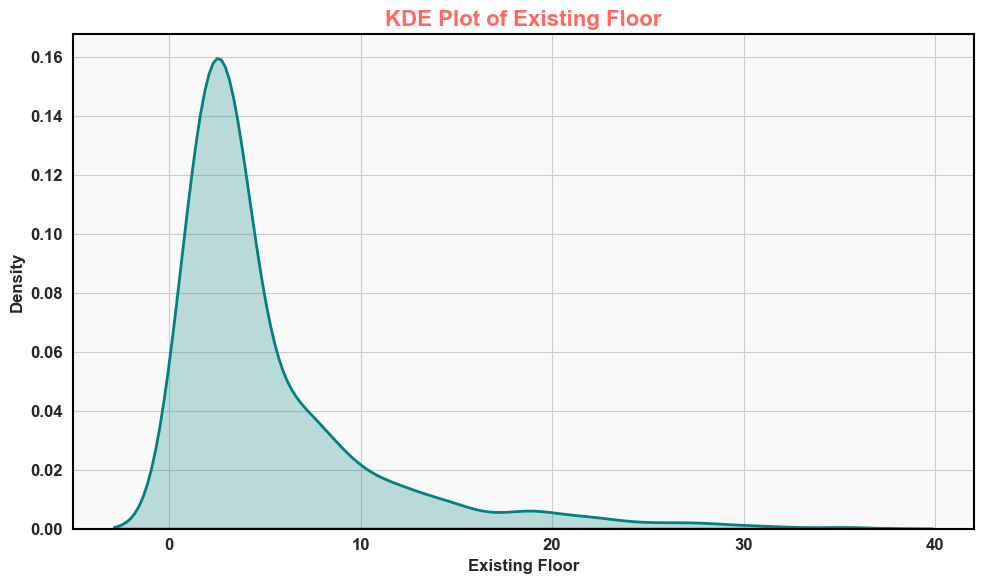

In [63]:
sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.facecolor": "#f9f9f9",     
    "figure.facecolor": "#ffffff",    
    "font.size": 12,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titlesize": 16,
    "axes.titleweight": "bold"
})

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(data=df, x="Existing Floor", fill=True, color="teal", linewidth=2, ax=ax)

# Labels and title
ax.set_title("KDE Plot of Existing Floor", fontsize=16, fontweight='bold', color="#FF6961")
ax.set_xlabel("Existing Floor", fontweight='bold')
ax.set_ylabel("Density", fontweight='bold')


#  Add visible plot borders (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

#  Layout
plt.tight_layout()
plt.show()

### __KDE Plot__

- A KDE plot shows the **probability density function** of a continuous variable.
- It provides a **smoothed curve** that represents the **distribution of data**, unlike histograms which are binned.
- Useful to observe the **shape**, **peaks**, and **spread** of the data.
- Helps identify:
  - **Central tendency**
  - **Skewness** (left or right)
  - **Multi-modal distributions** (more than one peak)
- Often used alongside histograms for better interpretation of numerical data.
- Smoother and more elegant than histograms, especially for presentations.
-----

### __Summary KDE Plot__

- Shows **smoothed distribution** of numerical data.
- Helps find **peaks**, **spread**, and **shape** of data.
- Better than histograms for spotting **underlying patterns**.
- Useful for **continuous variables** like area, price, etc.

-----

### __Insights of Existing Floors__

- The KDE plot shows the **distribution of properties based on their existing floor level**.
- The smooth curve helps identify which floors are **most commonly listed**.
- **Peaks in the curve** indicate the floors where the highest number of properties are located (e.g., Ground floor, 1st floor, etc.).
- The plot helps understand:
  - Whether lower or higher floors are **more prevalent** in listings.
  - If the distribution is **skewed** towards any specific floor range.
- Useful for:
  - **Buyers**, to know the most available floor levels.
  - **Builders/Investors**, to align supply with market demand.
-----

### __Summary Insights of Existing Floors__

- Shows which floors have the **most listings**.
- Smooth curve makes floor trends easy to spot.
- Helps compare **low-rise vs high-rise** preference.
- Useful for understanding **floor availability trends**.

<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#F0F7FF; padding:8px 15px; border-radius:8px; display:inline-block;">
  📈 Histogram View
</div>


# __Total Floors__

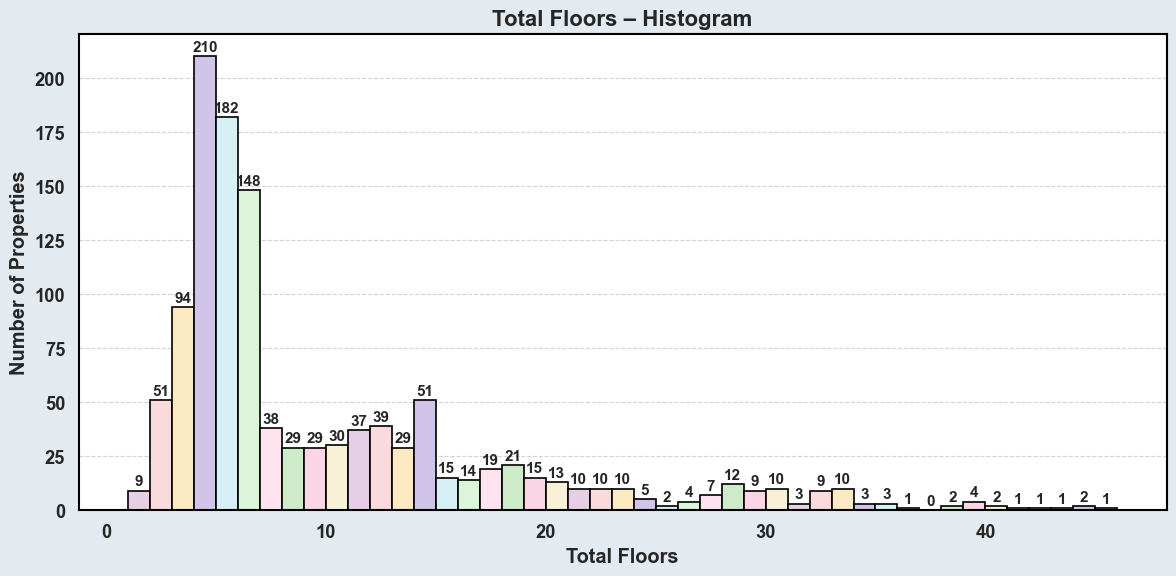

In [64]:
# 📂 Prepare Data
plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)

# Background
plt.gca().set_facecolor("white")
plt.gcf().patch.set_facecolor('#e3eaf0')

# Define your custom pastel colors (repeat if fewer than bins)
custom_colors = [
    "#E6CFE6", "#FADADD", "#FCEAC3", "#D1C4E9", "#D6F0F5",
    "#DCF5D8", "#FFE4F0", "#CDEBC9", "#F9D5E5", "#F7F0D6"
]

# Plot histogram using bar container
floor_values = df["Total Floors"]
n, bins, patches = plt.hist(floor_values, bins=range(int(floor_values.min()), int(floor_values.max())+2),
                            edgecolor='black', linewidth=1.2)

# Apply custom color to each bar
for patch, color in zip(patches, custom_colors * (len(patches) // len(custom_colors) + 1)):
    patch.set_facecolor(color)

# Annotate each bar
for i in range(len(patches)):
    plt.text(
        patches[i].get_x() + patches[i].get_width()/2,
        n[i] + 1,
        f"{int(n[i])}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# Titles and labels
plt.title("Total Floors – Histogram", fontsize=16, fontweight='bold')
plt.xlabel("Total Floors", fontweight='bold')
plt.ylabel("Number of Properties", fontweight='bold')

# Grid and spine styling
plt.grid(axis='y', color='lightgray', linestyle='--', linewidth=0.8)
plt.gca().xaxis.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tight_layout()
plt.show()


### __Insights from Histogram – Total Floors__

- The histogram reveals the **distribution of total floors** across listed properties.
- Most buildings in the dataset have **5 to 15 total floors**, indicating a preference for mid-rise apartments.
- A noticeable peak appears around **10 floors**, suggesting it is the most common building height.
- Very tall buildings (20+ floors) are relatively **rare**, possibly representing premium or luxury listings.
- Low-rise properties (1–4 floors) also exist, which could be independent homes, builder floors, or old constructions.
- The custom pastel color theme enhances visual appeal and makes the distribution easy to interpret.
------

### __Summary Insights of Total Floors__


- Most buildings have between **5 to 15 floors**.
- The **highest number of properties** are in **10-floor buildings**.
- Very tall buildings (**above 20 floors**) are **less common**.
- Some properties are in **low-rise buildings** (1–4 floors).
- This shows that **mid-rise apartments** are most popular in the data.

<div style="background:#FDF0D5; border:2px solid #F4A261; display:inline-block; padding:10px 20px; border-radius:25px; box-shadow:2px 2px 6px rgba(0,0,0,0.1); font-weight:bold; font-size:16px;">
  🗂️ For Categorical Column
</div>


<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#F0F8FF; padding:8px 15px; border-radius:8px; display:inline-block;">
  📊 Horizontal Bar Chart
</div>


# __Flat Type__

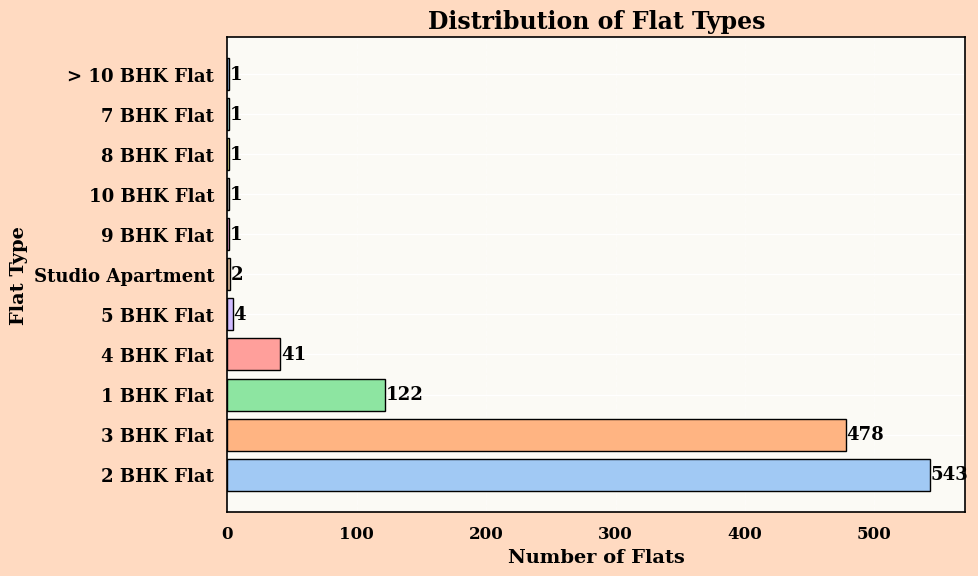

In [65]:
plt.figure(figsize=(10, 6))
flat_counts = df['Flat Type'].value_counts()

# Plot horizontal bars
bars = plt.barh(
    flat_counts.index,
    flat_counts.values,
    color=sns.color_palette('pastel'),
    edgecolor='black'
)

# Add ladder-style value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5,bar.get_y() + bar.get_height() / 2,str(int(width)),va='center',ha='left',fontsize=13,fontweight='bold',family='serif',
        color='black')

# Titles and axis styling (fonts changed as per request)
plt.title("Distribution of Flat Types", fontsize=17, fontweight='bold', family='serif', color='black')
plt.xlabel("Number of Flats", fontsize=14, fontweight='bold', family='serif', color='black')
plt.ylabel("Flat Type", fontsize=14, fontweight='bold', family='serif', color='black')

# Tick label fonts
plt.xticks(fontsize=12, family='serif', color='black')
plt.yticks(fontsize=13, family='serif', color='black')

# Grid and background
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.gca().set_facecolor("#FBFAF5")
plt.gcf().patch.set_facecolor("#FFDAC1")

# Keep all 4 borders (optional enhancement)
for side in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[side].set_visible(True)
    plt.gca().spines[side].set_color('black')
    plt.gca().spines[side].set_linewidth(1.2)

plt.tight_layout()
plt.show()

### __Horizontal Bar Chart__

- It is used to **visualize categorical data**.
- Bars run **horizontally**, making it easy to read long category names.
- Length of each bar represents the **count/frequency** of each category.
- Useful when comparing **discrete categories** (like flat types).
- Helps identify the **most and least frequent** categories quickly.
------

### `__Insights of Flat Type__

- The horizontal bar chart shows the **count of each flat type** (e.g., 1 BHK, 2 BHK, 3 BHK, etc.) listed in the dataset.
- It helps identify which flat types are **most commonly available** in the housing market.
- The **longest bar** indicates the **highest number of listings**, suggesting greater availability and possibly higher demand.
- The **shortest bar** shows the **least available flat type**, which may reflect either low supply or niche demand.
- This analysis is useful for:
  - **Buyers**, to understand what’s commonly available.
  - **Sellers or builders**, to align supply with market trends.
- The graph also helps spot any **imbalance in property types**, which can guide future development or investment strategies.
------

###  __Insights of Flat Type__

- Shows how many listings exist for each flat type.
- Most common flat types have the longest bars.
- Helps identify which flat types are in high or low supply.
- Useful for buyers to know availability.
- Useful for sellers to target popular configurations.


<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#FFF4E0; padding:8px 15px; border-radius:8px; display:inline-block;">
  🥧 Pie Chart View
</div>


# __City__

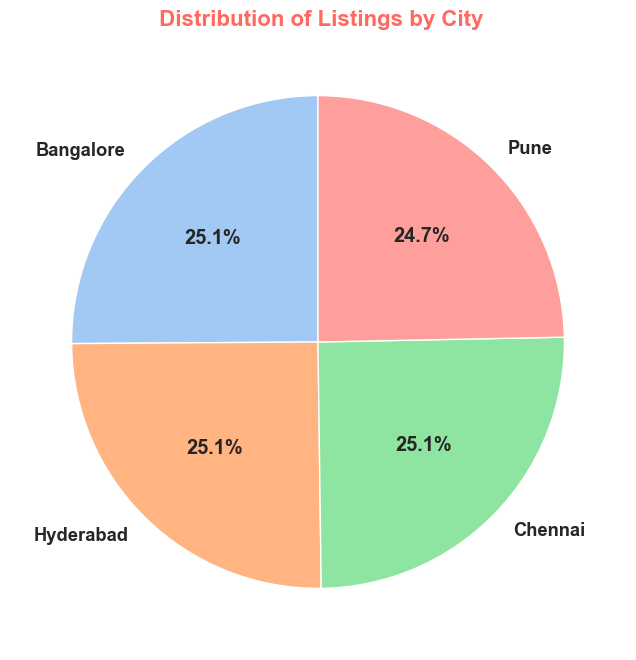

In [66]:
# City count
city_counts = df['City'].value_counts()

# Colors
colors = sns.color_palette("pastel")

# Plot
plt.figure(figsize=(8, 8))
plt.pie(
    city_counts,
    labels=city_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title(" Distribution of Listings by City", fontsize=16, color="#FF6961", weight='bold')
plt.show()

### __Pie Chart__

- A **pie chart** is a circular chart divided into slices.
- Each slice represents a **category** and its **proportion** in the dataset.
- Useful for showing **part-to-whole relationships**.
- Best for **categorical data** with limited distinct values.
- Easy to see which categories are **dominant or rare**.
- Not ideal for comparing similar-sized categories (bar charts work better in such cases).
-----

### __Insights – Distribution of Listings by City__

- The pie chart shows the distribution of property listings by city.
- This focused approach is useful for:
  - Studying **urban property trends** in Bangalore,
  - Identifying **local market dynamics**, and
  - Understanding **buyer/seller behavior** specific to the city.

<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#E8F6EF; padding:8px 15px; border-radius:8px; display:inline-block;">
  📊 Count Plot View
</div>


# __Interior Status__

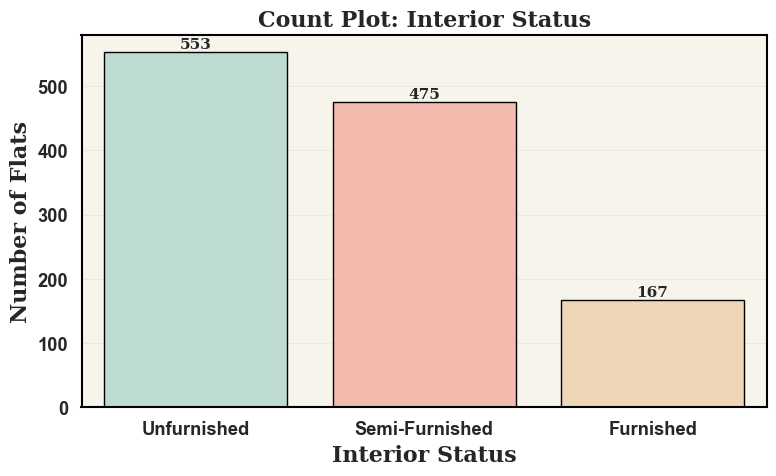

In [67]:
# Prepare data
status_counts = df['Interior Status'].value_counts()
order = status_counts.index

# Plot
plt.figure(figsize=(8, 5))
sns.set_style("whitegrid")

bar_colors = ['#F6D6AD', '#B8E0D2', '#FFB4A2']

ax = sns.countplot(
    data=df,
    x='Interior Status',
    hue='Interior Status',
    order=order,
    palette=bar_colors,
    edgecolor='black',)

# Add labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,height + 2,
        f'{int(height)}',ha='center',va='bottom',fontsize=11,fontweight='bold',family='serif')

# Title
plt.title("Count Plot: Interior Status", fontsize=16, fontweight='bold', family='serif')

# Custom X and Y labels
plt.xlabel("Interior Status", fontweight='bold', fontsize=16, family='serif')
plt.ylabel("Number of Flats", fontweight='bold', fontsize=16, family='serif')

# Light grid & background
plt.gca().set_facecolor('#F7F5EB')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.6)

# Draw border around entire plot area
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

plt.tight_layout()
plt.show()


### __Count Plot__

- A **Count Plot** is a type of bar chart used to visualize the **frequency (count)** of each category in a **categorical variable**.
- It is commonly used in **univariate analysis** to show how often each category appears in the dataset.
- On the x-axis, we have the **categories**, and on the y-axis, we have the **number of observations** (count).
- It helps identify:
  - Which categories are most or least frequent
  - Imbalances in the data
  - Patterns in user preferences or distributions
------

### __Insights of Interior Status__

- The count plot displays the **number of properties** under each `Interior Status` category — such as **Furnished**, **Semi-Furnished**, and **Unfurnished**.
- The **height of each bar** represents how many listings fall into that category.
- Clearly shows which furnishing type is the **most common** among the available flats.
- Helps in:
  - **Understanding buyer preferences** based on availability.
  - **Informing sellers/agents** about current inventory trends.
- Count labels and custom colors make the chart **easy to interpret** and visually appealing.
- Ideal for quick comparisons between furnishing categories in **univariate analysis**.
------

###  __Summary Insights of Interior Status (Count Plot)__

- Shows how many flats are Furnished, Semi-Furnished, or Unfurnished.
- The most common type can be identified by the tallest bar.
- Useful to understand what kind of interior setup is most available.
- Helps in comparing different furnishing categories quickly.
- Clean and clear visualization with labeled bars.


<div style="text-align:right; font-size:20px; font-weight:bold; color:#2c3e50; background-color:#FFF4E0; padding:8px 15px; border-radius:8px; display:inline-block;">
  🥧 Pie Chart View
</div>


# __Transaction__

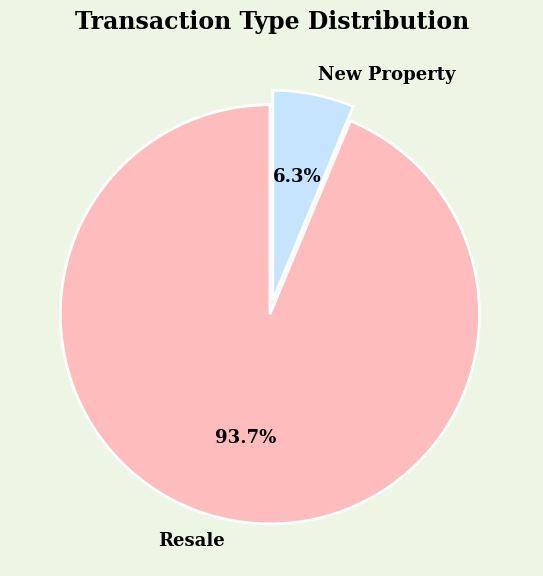

In [68]:
transaction_counts = df['Transaction'].value_counts()
labels = transaction_counts.index
sizes = transaction_counts.values

colors = ['#FFBCBC', '#C4E4FF']

# Explode the largest slice for emphasis
explode = [0.05 if size == max(sizes) else 0.02 for size in sizes]

# Plot the pie chart
fig, ax = plt.subplots(figsize=(7, 6))
ax.pie(sizes,labels=labels,explode=explode,colors=colors,autopct='%1.1f%%',startangle=90,
    textprops={'fontsize': 13, 'fontweight': 'bold', 'family': 'serif', 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Add a title
ax.set_title("Transaction Type Distribution", fontsize=17, fontweight='bold', family='serif', color='black', pad=10)

# Background color
fig.patch.set_facecolor('#EDF6E5')

plt.tight_layout()
plt.show()


### __Pie Chart__

- A **pie chart** is a circular chart divided into slices.
- Each slice represents a **category** and its **proportion** in the dataset.
- Useful for showing **part-to-whole relationships**.
- Best for **categorical data** with limited distinct values.
- Easy to see which categories are **dominant or rare**.
- Not ideal for comparing similar-sized categories (bar charts work better in such cases).
----

### __Insights of Transaction Type Distribution__

- The pie chart visualizes the proportion of properties listed as **Resale** and **New Booking**.
- The **larger slice** represents the **more common transaction type** in the dataset.
- In this case, if **Resale** dominates, it suggests a **second-hand property market is more active**.
- If **New Booking** dominates, it reflects a trend toward **new constructions and fresh listings**.
- The exploded slice helps draw attention to the **most frequent transaction type**.
- Useful for:
  - **Buyers**: Understanding whether more new or old properties are on the market.
  - **Sellers/Developers**: Gauging market preference and competition.
-----

### __Summary Insights of Transaction Type Distribution__

- Pie chart shows share of Resale vs New Booking properties.
- Larger slice = more listings of that transaction type.
- Helps identify which type is more common in the housing market.
- Visually emphasizes the dominant category using the exploded slice.

<h2 style="text-align:center; font-weight:bold; color:#8E24AA; background-color:#F3E5F5; padding:12px 20px; border-radius:10px;">
   🔗 Bivariate Analysis
</h2>


###  **What is Bivariate Analysis?**

-  It involves analyzing **two variables together** to find patterns and relationships.
-  Helps determine how **one variable affects or relates to another**.
-  Useful for detecting **correlation**, **association**, or **dependency** between features.
-  A key step in **feature selection** and understanding **data behavior**.
-  Unlike univariate analysis, it looks at the **interaction** between columns.
-  Typically used in the **second phase** of EDA after univariate exploration.


### __Types of Bivariate Analysis__

| Type of Variable 1 | Type of Variable 2 | Plot/Analysis Techniques                         |
|--------------------|--------------------|--------------------------------------------------|
| Categorical        | Categorical        | Grouped Bar Chart, Heatmap, Mosaic Plot         |
| Categorical        | Numerical          | Box Plot, Violin Plot, Strip Plot, Bar Plot     |
| Numerical          | Numerical          | Scatter Plot, Line Plot, Hexbin, Correlation    |


<div style="background:#FFF4E0; border-left:6px solid #FF914D; padding:10px 18px; border-radius:8px; font-size:20px; font-weight:bold; color:#4B1E00; display:inline-block;">
  🧩 Categorical vs Categorical
</div>



<div style="text-align:right; font-size:20px; font-weight:bold; color:#1c1c1c; background-color:#E0F7FA; padding:8px 15px; border-radius:8px; display:inline-block;">
  📊 Grouped Bar Chart View
</div>


# __Transaction VS Interior Status__

- Why: Discover furnishing patterns in new vs resale flats
- Plot: Grouped Count Plot
- Insight Goal: Are new properties more often unfurnished?
- Understand which type of property (new/resale) is more furnished

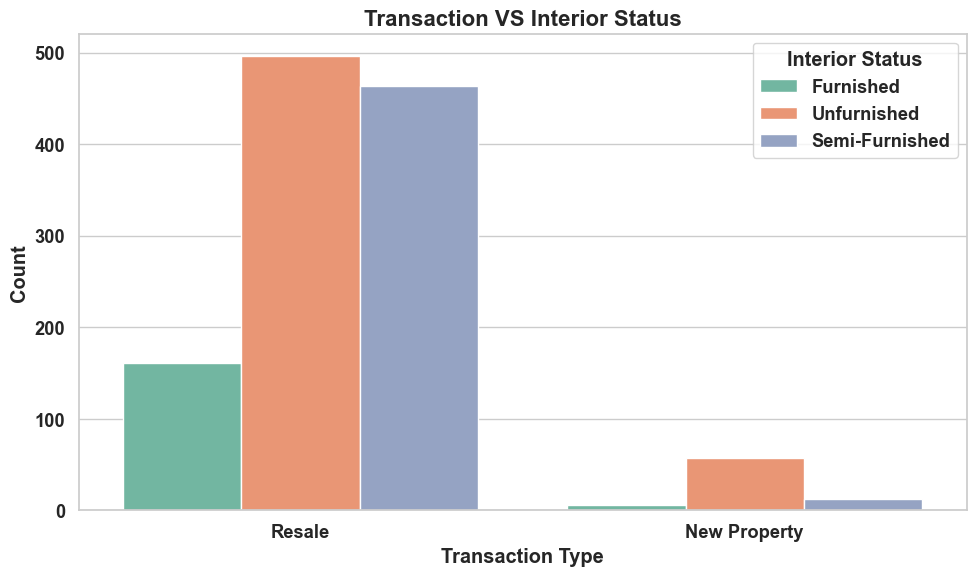

In [70]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="Transaction", hue="Interior Status", palette="Set2")

plt.title("Transaction VS Interior Status", fontsize=16, fontweight='bold')
plt.xlabel("Transaction Type", fontweight='bold')
plt.ylabel("Count", fontweight='bold')
plt.legend(title="Interior Status")
plt.tight_layout()
plt.show()

###  __Grouped Bar Chart__

- Used to **compare two categorical variables** side by side.
- Displays **counts or values grouped by a second category**.
- Each group is represented by **multiple bars**, one for each sub-category.
- Makes it easy to:
  - Compare distributions across groups
  - Spot patterns or dominance in categories
  - Detect imbalances or trends
-----

### __Insights: Transaction Type vs Interior Status__

-  **Resale properties** dominate the dataset compared to new properties.
-  Among resale properties, **semi-furnished** and **unfurnished** units are most common.
-  **Furnished units** are relatively fewer in both transaction types.
-  New properties tend to be **mostly unfurnished**, indicating raw delivery by builders.
- Buyers may need to invest in furnishing when opting for new properties.
- This relationship helps understand **market preferences** and **builder practices**.
-----

### __Summary Insights: Transaction Type vs Interior Status__

- Resale properties are more common than new ones.
- Most resale properties are semi-furnished or unfurnished.
- Furnished homes are the least common.
- New properties are usually unfurnished.
- Buyers may need to furnish new homes themselves.
- Helps understand interior trends and builder practices.


<div style="text-align:right; font-size:20px; font-weight:bold; color:#4A148C; background-color:#EDE7F6; padding:8px 15px; border-radius:8px; display:inline-block;">
  🌡️ Heatmap View
</div>


# __Flat Type vs City__

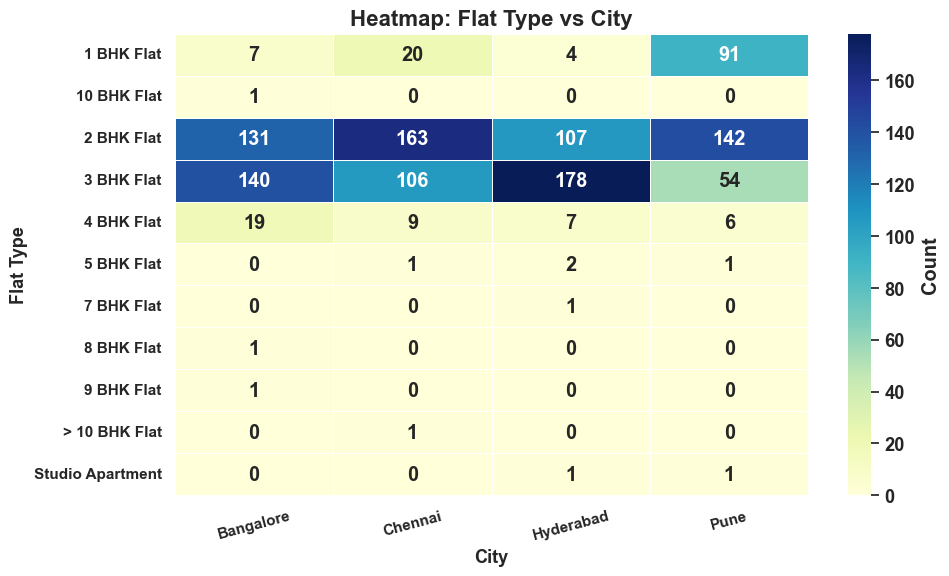

In [71]:
# Prepare the data: create a frequency table
flat_city_crosstab = pd.crosstab(df["Flat Type"], df["City"])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    flat_city_crosstab,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={"label": "Count"}
)

# Titles and labels
plt.title("Heatmap: Flat Type vs City", fontsize=16, fontweight='bold')
plt.xlabel("City", fontsize=13, fontweight='bold')
plt.ylabel("Flat Type", fontsize=13, fontweight='bold')

# Make X and Y tick labels bold
plt.xticks(fontsize=11, fontweight='bold', rotation=15)
plt.yticks(fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


### 
__Heatmap__

- Used to **visualize the relationship** between two categorical variables using **color intensity**.
- Displays a **matrix-like table**, where:
  - Rows represent one category
  - Columns represent another
  - Cell color indicates the count or magnitude
- Makes it easy to:
  - Detect **patterns**, **correlations**, or **clusters**
  - Identify **highs and lows** quickly through color shades
  - Summarize **dense categorical data** in a compact form
-------

### __Insights: Flat Type vs City__

- Clearly shows which flat types are **most common in each city**.
- Some cities may show concentration in specific flat types (e.g., mostly 2 BHK or 3 BHK).
- Darker-colored cells represent **higher property counts**, making it easy to identify hotspots.
- Helps understand **urban housing preferences** by flat size across different cities.
- Useful for identifying demand trends and guiding city-specific marketing or development strategies.

-----

### 📊 Summary Insights: 2 BHK & 3 BHK vs City

- **2 BHK and 3 BHK flats dominate** the listings across all cities.
- **Hyderabad** has the highest combined number of these two flat types (**285**), with a strong presence of **3 BHKs**.
- **Chennai** shows a slightly higher preference for **2 BHKs** over 3 BHKs.
- **Pune** has the **lowest combined total (**196**), with 2 BHKs being far more common than 3 BHKs.
- **Bangalore** maintains a balanced distribution between 2 BHK and 3 BHK.
- This heatmap highlights **which flat types are most in demand in each city**, making it useful for targeted housing insights.


<div style="text-align:right; font-size:20px; font-weight:bold; color:#4B1E00; background-color:#FFF4E0; padding:8px 15px; border-radius:8px; display:inline-block;">
  🗂️ Numerical vs Categorical
</div>


<div style="text-align:right; font-size:20px; font-weight:bold; color:#003f5c; background-color:#FFF3E0; padding:8px 15px; border-radius:8px; display:inline-block;">
  📊 Bar Plot View
</div>


# __Average Area by Flat Type__

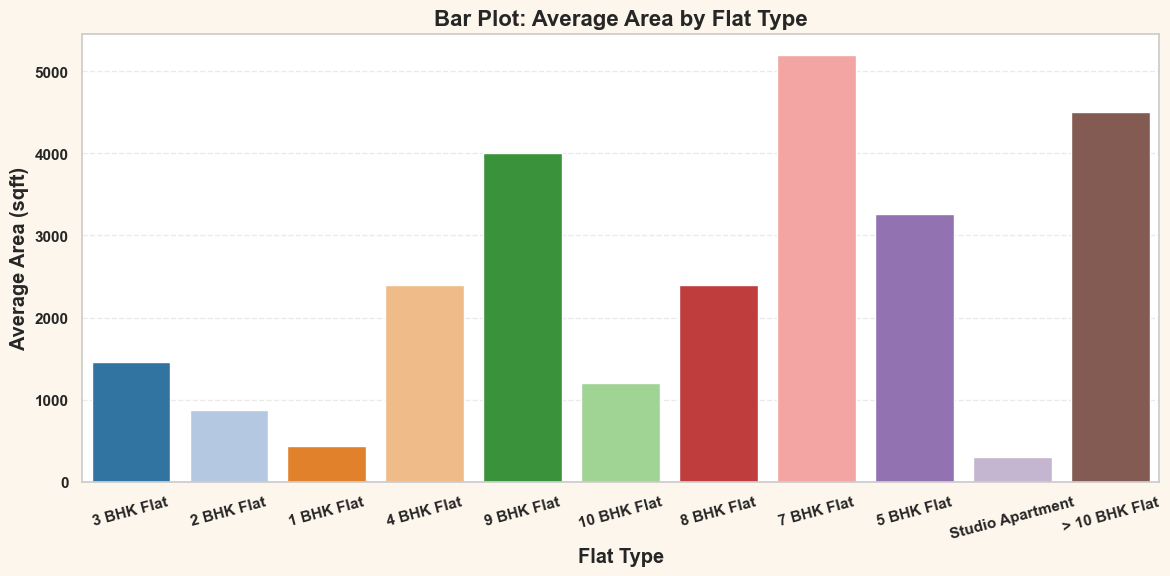

In [73]:
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Get number of unique Flat Types
flat_types = df["Flat Type"].nunique()

# Use a large palette that supports many distinct categories
palette = sns.color_palette("tab20", flat_types)

# Bar plot
sns.barplot(data=df,x="Flat Type",y="Area(sqft)",hue="Flat Type",legend=False,estimator=np.mean,errorbar=None,palette=palette)
ax.set_facecolor("#FAF3E0")                 
plt.gcf().patch.set_facecolor("#FDF6EC")

# Title & Labels
plt.title("Bar Plot: Average Area by Flat Type", fontsize=16, fontweight='bold')
plt.xlabel("Flat Type", fontweight='bold')
plt.ylabel("Average Area (sqft)", fontweight='bold')

# Formatting
plt.xticks(rotation=15, fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.4)

for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
    spine.set_color('#333333')


plt.tight_layout()
plt.show()


### __Bar Plot__

- A **bar plot** is used to compare the values of **different categories**.
- It shows **categorical data** on the X-axis and **numerical values** on the Y-axis.
- Each bar represents the **average, total, or count** of values for that category.
- It’s great for answering questions like:
  - Which category has the highest or lowest value?
  - How do values vary across different groups?
- Bar plots are simple, clear, and widely used in data analysis.

------

### __Insights: Average Area by Flat Type__

- 3 BHK flats have the largest average area among all flat types.
- 1 BHK flats show a significantly smaller average area.
- The average area increases consistently with the number of bedrooms.
- This plot clearly illustrates the size categorization of different flat types.
- Helps identify the relationship between flat configuration and space offered.
- Useful for comparing the area requirements for different buyer segments.


<div style="text-align:right; font-size:20px; font-weight:bold; color:#00695C; background-color:#E0F2F1; padding:8px 15px; border-radius:8px; display:inline-block;">
  📊 Numerical vs Numerical
</div>


# __Area vs Total Floors__

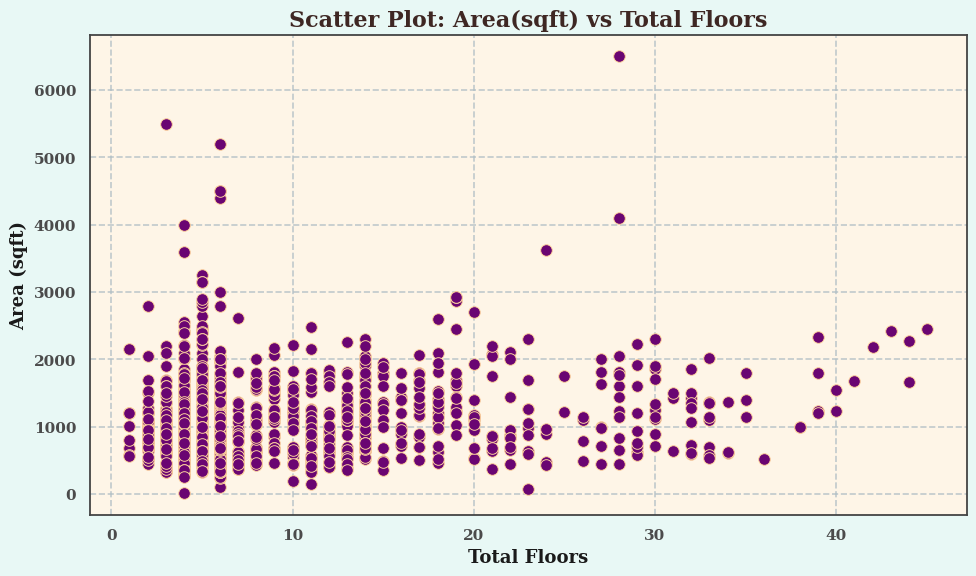

In [74]:
# Set style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter Plot
sns.scatterplot(
    data=df,
    x="Total Floors",
    y="Area(sqft)",color="#6A0572",edgecolor="#FFD59E",s=70)

# Title and axis labels
ax.set_title("Scatter Plot: Area(sqft) vs Total Floors", fontsize=16, fontweight='bold', color="#3E2723")
ax.set_xlabel("Total Floors", fontsize=13, fontweight='bold', color='#1A1A1A')
ax.set_ylabel("Area (sqft)", fontsize=13, fontweight='bold', color='#1A1A1A')

# Tick styling
plt.xticks(fontsize=11, fontweight='bold', color='#4B4B4B')
plt.yticks(fontsize=11, fontweight='bold', color='#4B4B4B')

# 🔹 Highlighted Grid Lines
plt.grid(which='major', axis='both', color='#B0BEC5', linestyle='--', linewidth=1.2, alpha=0.8)

# Background color
ax.set_facecolor("#FEF5E7")     # Plot area
fig.patch.set_facecolor("#E8F8F5")  # Outer figure

# Borders
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.3)
    spine.set_color("#444")

# Layout
plt.tight_layout()
plt.show()


### 
__Scatter Plot__

- A scatter plot shows the relationship between **two numeric columns**.
- Each dot represents **one property/row** in the dataset.
- The X-axis shows one numeric feature, and the Y-axis shows another.
- Helps us:
  - Identify **patterns or trends**
  - Spot **outliers**
  - Check if the two variables are **related or correlated**
- If dots form a line or curve → the variables are likely related.
- If dots are spread randomly → there is **no clear relationship**.

-----

### __Insight – Scatter Plot: Area(sqft) vs Total Floors__

- The scatter plot shows **no strong correlation** between building height and flat size.
- Most flats are clustered between **1000 to 2000 sqft**, across buildings of various heights.
- Some high-rise buildings (above 15 floors) contain **larger flats** (above 2500 sqft), possibly luxury units.
- Large flats are also present in **mid-rise buildings**, indicating that area doesn’t strictly depend on the number of floors.
- A few **outliers** with very high area values suggest the presence of **premium or unique apartments**.


<h2 style="text-align:center; font-weight:bold; color:#2E7D32; background-color:#E8F5E9; padding:12px 20px; border-radius:10px;">
   📊 Multivariate Analysis
</h2>


### __Multivariate Analysis__

- Multivariate analysis involves analyzing **three or more variables** together.
- It helps uncover **complex relationships** and **interactions** between variables.
- Used to observe how one variable is affected by two or more others.
- Often used with **hue**, **size**, or **style** in visualizations like scatter plots, box plots, and heatmaps.
- It gives **deeper insights** compared to univariate or bivariate analysis.
- Essential in real-world datasets like real estate, healthcare, or marketing.

## __Multivariate Plot Types__

| Plot Type                 | Variable Types Involved                 | Description / Use Case                                        |
|--------------------------|-----------------------------------------|---------------------------------------------------------------|
| Scatter Plot with Hue    | Numeric vs Numeric + Categorical (Hue)  | Shows correlation and subgroup patterns                       |
| Boxplot with Hue         | Numeric vs Categorical + Hue            | Compare distributions across multiple categories              |
| Violin Plot with Hue     | Numeric vs Categorical + Hue            | Similar to boxplot but also shows KDE                         |
| Bar Plot with Hue        | Categorical vs Aggregated Numeric + Hue | Compare means or counts across subgroups                     |
| Swarm/Strip Plot with Hue| Numeric vs Categorical + Hue            | Visualize individual points by group                          |
| Pair Plot                | Multiple Numeric + Categorical (Hue)    | All pairwise scatter plots with optional category separation  |
| Heatmap (with Annotation)| Multiple Categorical (pivoted) + Numeric| Visualizes frequency, correlation, or values in matrix form   |
| FacetGrid/Subplots       | Any combo, split into subplots          | Helps compare patterns across subgroups using small multiples |
| 3D Scatter Plot          | 3 Numerical Variables                   | Explore spatial relationships (using matplotlib or plotly)    |


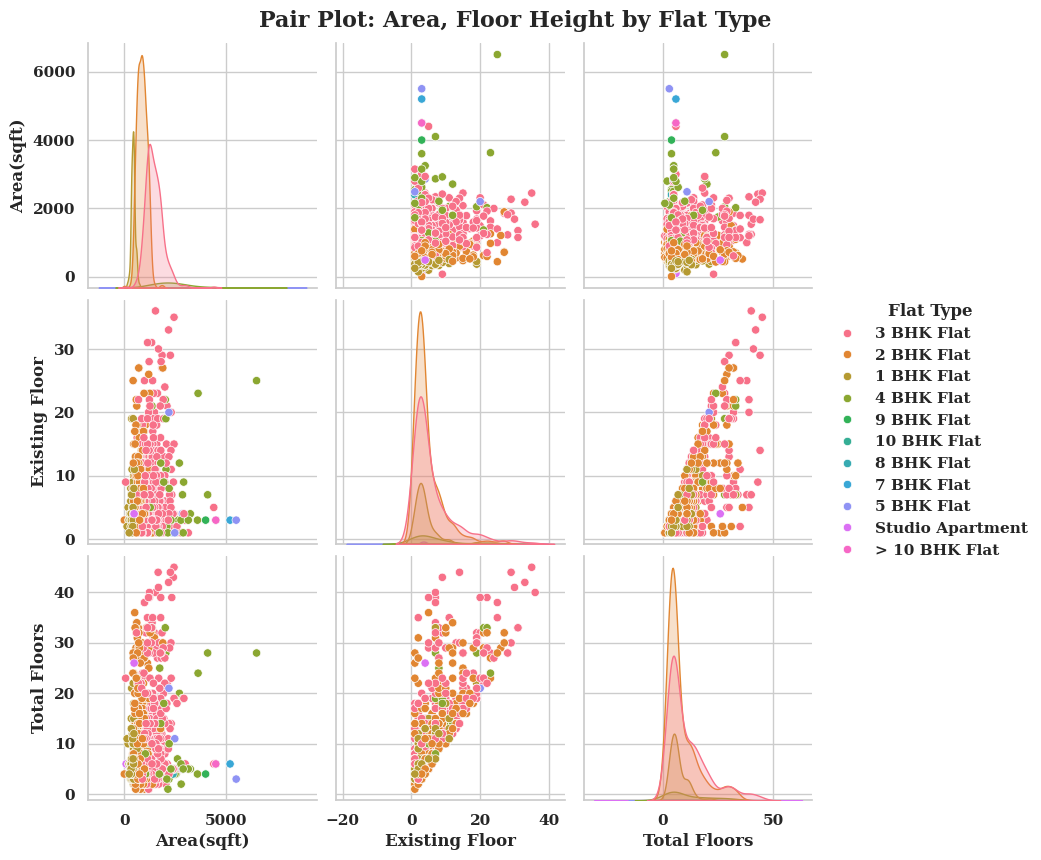

In [75]:
sns.set(style="whitegrid", palette="husl")
plt.rcParams["font.family"] = "serif"

# Pair Plot using Flat Type as hue
sns.pairplot(
    df[["Area(sqft)", "Existing Floor", "Total Floors", "Flat Type"]],
    hue="Flat Type",
    palette="husl",       # Bright, distinct colors
    diag_kind="kde",      # KDE for diagonals instead of hist
    height=2.8
)

plt.suptitle("Pair Plot: Area, Floor Height by Flat Type", fontsize=16, fontweight="bold", y=1.02)
plt.show()


### __Insights: Correlation Analysis__

- **Correlation measures** the strength and direction of the linear relationship between two **numerical variables**.
- Values range from **-1 to +1**:
  - `+1` → strong positive correlation (as one increases, so does the other).
  - `-1` → strong negative correlation (as one increases, the other decreases).
  - `0` → no linear correlation.
- Helps identify **which variables move together** and can influence each other.
- High correlations can indicate **multicollinearity**, which is important in modeling.

-----

### __Pair Plot Insights__

- **1 BHK flats** usually fall in the range of **500–700 sqft**, often on **lower floors**, and are mostly in **low-rise buildings**.
- **2 BHK flats** generally range from **800–1200 sqft**, found across **low to mid floors**, in **mid-rise buildings**.
- **3 BHK and 4 BHK flats** have larger areas (**1300–2500+ sqft**) and are frequently located on **higher floors**, within **taller buildings**.
- **Larger flats (3/4 BHK)** show a tendency to be part of **high-rise buildings**, indicating a premium segment targeting.
- A **positive trend** is visible: as the `Area(sqft)` increases, both `Existing Floor` and `Total Floors` also tend to increase.
- Some **outliers** exist (e.g., 2 BHKs with unusually high area or 1 BHKs in high-rises), which may represent luxury listings or data issues.
- The distribution of flats by type is **well-separated** by area and floor configuration.
- This plot provides a **clear understanding of how flat size correlates with floor levels and building height**.
- Insights here are useful for **property segmentation, pricing strategy**, and **real estate planning**.

-------

### __Summary Insights from Pair Plot__

- 1 BHK flats are small (500–700 sqft) and usually found on lower floors.
- 2 BHK flats range from 800–1200 sqft and are in mid-rise buildings.
- 3 BHK and 4 BHK flats are larger (1300–2500+ sqft) and often in high-rise towers.
- Larger flats are typically located on higher floors.
- Bigger buildings tend to contain bigger flats.
- A few outliers exist (e.g., very large 2 BHKs or high-floor 1 BHKs).
- Overall, flat type clearly influences area, floor level, and building height.

<h2 style="text-align:center; font-weight:bold; color:#6A1B9A; background-color:#F3E5F5; padding:12px; border-radius:10px;">
  🚨 Outliers Analysis
</h2>


## __Outlier__

- An outlier is a value that is **very different** from other values in the data.
- It lies **far away** from most of the data points.
- Outliers can happen due to **errors** or **unusual cases**.
- Example: If most flat areas are 1000–2000 sqft and one is 10,000 sqft, that is an outlier.

---

### __Why Outliers Matter__

- They can **affect averages** and **change results**.
- They might show **important hidden patterns**.
- We should **check** and **handle** them carefully.


## __Outlier Handling Techniques__

| Method                     | Description                                                      | Best For                      |
|----------------------------|------------------------------------------------------------------|-------------------------------|
| **Removal**                | Drop rows where values fall outside IQR/3σ limits               | Clean datasets where outliers are errors |
| **Capping (Winsorization)**| Replace extreme values with upper/lower percentiles             | Skewed data with extreme values |
| **Transformation**         | Apply log, square root, or Box-Cox to reduce impact             | Highly skewed distributions    |
| **Imputation**             | Replace outliers with mean, median, or mode                     | When keeping data size matters |
| **Binning**                | Convert numerical values to categorical bins                    | Reducing impact of extremes    |
| **Model-Based Methods**    | Use models (e.g., Isolation Forest, Z-Score) to detect/remove   | Large, complex datasets        |
| **Clipping**               | Manually set a maximum/minimum allowed value                    | Real-world thresholds (e.g., salary limits) |



In [77]:
# Define numerical columns
numerical_cols = ["Area(sqft)"]

# Outlier detection using IQR
outlier_counts = {}

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_counts[col] = len(outliers)

# Convert to DataFrame to view sorted results
outlier_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=["Outlier Count"])
outlier_df = outlier_df.sort_values(by="Outlier Count", ascending=False)
outlier_df


,Outlier Count
Area(sqft),39


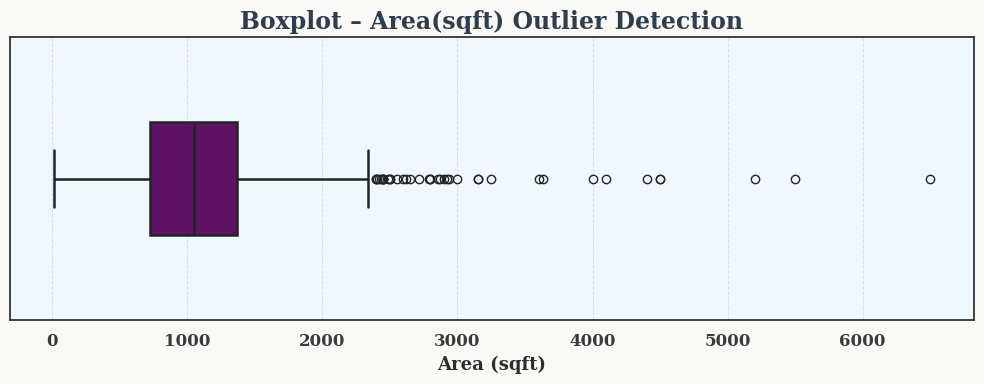

In [78]:
# Set seaborn style and font
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif"

# Set figure
plt.figure(figsize=(10, 4))

# Custom violet tone
custom_color = ["#6A0572"]

# Horizontal boxplot without warning
sns.boxplot(
    data=df,
    x="Area(sqft)",color=custom_color[0],linewidth=1.8,width=0.4)

# Title & labels
plt.title("Boxplot – Area(sqft) Outlier Detection", fontsize=17, fontweight='bold', color="#2C3E50")
plt.xlabel("Area (sqft)", fontsize=13, fontweight='bold', color="#2E2E2E")
plt.ylabel("")

# Tick styling
plt.xticks(fontsize=12, fontweight='bold', color='#3B3B3B')

# Grid & backgrounds
plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.6)
plt.gca().set_facecolor("#F0F8FF")         # Alice Blue
plt.gcf().patch.set_facecolor("#FAF9F6")   # Off white

# Bold plot border
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.3)
    spine.set_color("#333")

# Display
plt.tight_layout()
plt.show()
